### 环境初始化

In [1]:
# 在jupyter notebook里env.render看不到窗口
# 写一个helper类，用matplotlib刷新显示图像
# 初始化传入env，调用helper的render即可
from IPython import display # 导入display模块，用于在Jupyter Notebook中显示图像
import matplotlib
import matplotlib.pyplot as plt # 导入matplotlib库，用于绘制图像
%matplotlib inline

class GymHelper:
    def __init__(self, env, figsize = (3, 3)):
        self.env = env # 初始化Gym环境
        self.figsize = figsize # 初始化绘图窗口大小
        
        plt.figure(figsize = figsize) # 创建绘图窗口
        plt.title(self.env.metadata['name']) # 标题设为环境名
        self.img = plt.imshow(env.render()) # 在绘图窗口中显示初始图像
    
    def render(self, title = None):
        image_data = self.env.render() # 获取当前环境图像渲染数据
        
        self.img.set_data(image_data) # 更新绘图窗口中的图像数据
        display.display(plt.gcf()) # 刷新显示
        display.clear_output(wait = True) # 有新图片时再清除绘图窗口原有图像
        if title: # 如果有标题，就显示标题
            plt.title(title)

### 多智能体环境

执行 pip install pettingzoo==1.23.1 即可安装。

https://pettingzoo.farama.org/environments/mpe/simple_spread/

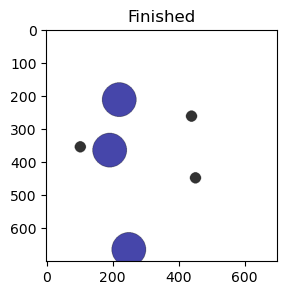

In [2]:
# 加载pettingzoo
from pettingzoo.mpe import simple_spread_v3

# 创建环境，指定渲染模式为rgb_array
env = simple_spread_v3.parallel_env(N = 3, max_cycles = 50, 
                                    render_mode = 'rgb_array', continuous_actions = True)
# 重置环境
observations, _ = env.reset()
# 创建GymHelper
gym_helper = GymHelper(env)
# 重置步数
steps = 0

# 开始循环
while env.agents:
    # 渲染环境，title为当前步数
    gym_helper.render(title = str(steps))
    # 从动作空间中随机选取动作
    actions = {agent: env.action_space(agent).sample() for agent in env.agents}  
    # 执行action，获取新的信息
    observations, rewards, terminations, truncations, infos = env.step(actions)
    # 记录步数
    steps += 1

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()

In [3]:
observations, rewards, terminations, truncations

({'agent_0': array([-0.12203537, -0.15697908, -0.34329745,  0.37129653,  0.5905623 ,
         -0.13607581,  0.62283367, -0.6354764 , -0.31667632, -0.38397613,
         -0.07715695, -0.41063723,  0.08004795, -1.2190971 ,  0.        ,
          0.        ,  0.        ,  0.        ], dtype=float32),
  'agent_1': array([ 0.17568643,  0.14516462, -0.4204544 , -0.03934069,  0.66771924,
          0.2745614 ,  0.69999063, -0.22483923, -0.23951936,  0.02666109,
          0.07715695,  0.41063723,  0.15720491, -0.80845994,  0.        ,
          0.        ,  0.        ,  0.        ], dtype=float32),
  'agent_2': array([-0.02898435,  0.5555049 , -0.26324952, -0.8478006 ,  0.5105143 ,
          1.0830213 ,  0.5427857 ,  0.5836207 , -0.39672425,  0.835121  ,
         -0.08004795,  1.2190971 , -0.15720491,  0.80845994,  0.        ,
          0.        ,  0.        ,  0.        ], dtype=float32)},
 defaultdict(int,
             {'agent_0': -0.7911246085654455,
              'agent_1': -0.7911246085654

### MADDPG

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# 演员网络（策略网络）
class ActorNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNetwork, self).__init__()
        
        # 定义全连接网络
        self.fc = nn.Sequential(
            nn.Linear(state_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, action_dim)
        )
        
        # 使用Adam优化器
        self.optimizer = optim.Adam(self.parameters(), lr=0.0001)  
        self.apply(weight_init)  # 初始化模型权重

    # 前向传播过程
    def forward(self, state):
        # 输出动作，通过tanh激活函数，并进行缩放和平移，使其落在[0,1]范围内
        action = torch.tanh(self.fc(state)) * 0.5 + 0.5
        return action

# 评论家网络（价值网络）
class CriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticNetwork, self).__init__()
        
        # 定义全连接网络
        self.fc = nn.Sequential(
            nn.Linear(state_dim + action_dim, 512), # 输入维度为状态维度+动作维度
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
        )
        self.q = nn.Linear(512, 1)  # 输出Q值的全连接层

        # 使用Adam优化器
        self.optimizer = optim.Adam(self.parameters(), lr=0.001, weight_decay=0.001)  
        self.apply(weight_init)  # 初始化模型权重

    # 前向传播过程，输出Q值
    def forward(self, state, action):
        x = torch.cat([state, action], dim = 1)
        x = self.fc(x)
        q = self.q(x)  
        return q

# 初始化模型权重的函数
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1.0)
        nn.init.constant_(m.bias, 0.0)

In [5]:
# 经验回放缓冲区
class ReplayBuffer:
    def __init__(self, max_size, state_dim, action_dim, batch_size):
        # 初始化回放缓冲区的大小、批次大小、状态维度、动作维度
        self.mem_size = max_size
        self.batch_size = batch_size
        self.mem_cnt = 0
        
        self.state_dim = state_dim
        self.action_dim = action_dim

        # 创建用于存储经验的数组
        self.state_memory = np.zeros((self.mem_size, state_dim))  # 存储状态
        self.action_memory = np.zeros((self.mem_size, action_dim))  # 存储动作
        self.reward_memory = np.zeros((self.mem_size, ))  # 存储奖励
        self.next_state_memory = np.zeros((self.mem_size, state_dim))  # 存储下一个状态
        self.terminal_memory = np.zeros((self.mem_size, ), dtype=bool)  # 存储终止标志

    def store_transition(self, state, action, reward, next_state, done):
        # 存储经验转换
        mem_idx = self.mem_cnt % self.mem_size

        self.state_memory[mem_idx] = state
        self.action_memory[mem_idx] = action
        self.reward_memory[mem_idx] = reward
        self.next_state_memory[mem_idx] = next_state
        self.terminal_memory[mem_idx] = done

        self.mem_cnt += 1

    def sample_buffer(self):
        # 从缓冲区中随机采样一个批次的经验转换
        mem_len = min(self.mem_size, self.mem_cnt)
        batch = np.random.choice(mem_len, self.batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        next_states = self.next_state_memory[batch]
        terminals = self.terminal_memory[batch]

        return states, actions, rewards, next_states, terminals

    def ready(self):
        # 判断缓冲区是否已准备好进行采样
        return self.mem_cnt >= self.batch_size

In [6]:
import numpy as np
import torch.nn.functional as F

class DDPG:
    def __init__(self, env, gamma=0.99, tau=0.005, action_noise=0.05, max_size=5000000, batch_size=256):
        
        # 定义环境的state和action的维度
        self.state_dim = env.observation_space(env.agents[0]).shape[0]
        self.action_dim = env.action_space(env.agents[0]).shape[0]
        
        # 初始化DDPG算法的超参数和网络模型
        self.gamma = gamma  # 折扣因子
        self.tau = tau  # 软更新系数
        self.action_noise = action_noise  # 动作噪声幅度
        
        # agent的id和数量
        self.agent_ids = env.agents
        self.n_agents = len(env.agents)
        
        # 判断可用的设备是 CPU 还是 GPU
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 创建actor网络，每个agent都需要创建一个对应的网络
        self.actors = [ActorNetwork(
            state_dim = self.state_dim, action_dim = self.action_dim
        ).to(self.device) for _ in range(self.n_agents)]
        # 创建目标actor网络，同样是每个agent一个
        self.target_actors = [ActorNetwork(
            state_dim = self.state_dim, action_dim = self.action_dim
        ).to(self.device) for _ in range(self.n_agents)]
        
        # 创建critic网络
        self.critic = CriticNetwork(state_dim=self.state_dim * self.n_agents,
                                  action_dim=self.action_dim * self.n_agents).to(self.device)
        # 创建目标critic网络
        self.target_critic = CriticNetwork(state_dim=self.state_dim * self.n_agents,
                                  action_dim=self.action_dim * self.n_agents).to(self.device)

        # 创建回放缓冲区
        self.memory = ReplayBuffer(max_size=max_size, state_dim=self.state_dim * self.n_agents,
                                  action_dim=self.action_dim * self.n_agents, batch_size=batch_size)
        
        # 初始化目标网络参数与主网络参数相同
        self.update_network_parameters(tau=1.0)

    # 更新目标网络参数
    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        # 遍历每个target_actor并更新参数
        for actor, target_actor in zip(self.actors, self.target_actors):
            for actor_params, target_actor_params in zip(actor.parameters(),
                                                         target_actor.parameters()):
                target_actor_params.data.copy_(tau * actor_params + (1 - tau) * target_actor_params)

        # 更新target_critic网络参数
        for critic_params, target_critic_params in zip(self.critic.parameters(),
                                                       self.target_critic.parameters()):
            target_critic_params.data.copy_(tau * critic_params + (1 - tau) * target_critic_params)

    def remember(self, state, action, reward, next_state, done):
        # 定义存储dict
        transitions = {
            "state": np.array([], dtype=float),
            "action": np.array([], dtype=float),
            "reward": np.array([0.0], dtype=float),
            "next_state": np.array([], dtype=float),
            "done": np.array([False], dtype=bool),
        }
        # 遍历agent并对数据进行拼接，reward取和、done取或即可
        for agent_id in self.agent_ids:
            transitions["state"] = np.hstack((transitions["state"], state[agent_id]))
            transitions["action"] = np.hstack((transitions["action"], action[agent_id]))
            transitions["reward"] += reward[agent_id]
            transitions["next_state"] = np.hstack((transitions["next_state"], next_state[agent_id]))
            transitions["done"] = transitions["done"] or done[agent_id]
            
        # 存储经验转换
        self.memory.store_transition(transitions["state"], transitions["action"], transitions["reward"], 
                                     transitions["next_state"], transitions["done"])

    # 根据当前状态选择动作
    def choose_action(self, observation, train=True):
        actions = {}
        with torch.no_grad():
            for actor, agent_id in zip(self.actors, observation):
                # 将状态转化为tensor并传递给actor生成动作
                state = torch.FloatTensor(np.array([observation[agent_id]])).to(self.device)
                action = actor(state).squeeze()
            
                # 训练阶段添加一些噪声提高探索性
                if train:
                    noise = torch.tensor(np.random.normal(loc=0.0, scale=self.action_noise, size=(action.shape)),
                                 dtype=torch.float).to(self.device)
                    action = torch.clamp(action + noise, 0, 1)
                
                # 拼接动作
                actions[agent_id] = action.cpu().detach().numpy()
        return actions

    def learn(self):
        # 使用经验回放进行训练
        if not self.memory.ready():
            return
        
        # 从回放缓冲区中获取一批样本
        states, actions, rewards, next_states, dones = self.memory.sample_buffer()
        states = torch.FloatTensor(np.array(states)).to(self.device)
        actions = torch.FloatTensor(np.array(actions)).to(self.device)
        rewards = torch.FloatTensor(np.array(rewards)).to(self.device)
        next_states = torch.FloatTensor(np.array(next_states)).to(self.device)
        dones = torch.LongTensor(np.array(dones)).to(self.device)
        
        # 使用目标演员网络生成下一个状态对应的下一个动作，并计算目标评论家网络对应的 Q 值。
        with torch.no_grad():
            next_actions = []
            # 遍历每个agent对应的actor
            for i in range(len(self.agent_ids)):
                # 将拼接后的state分段送入各个actor
                next_act = self.target_actors[i](next_states[:,self.state_dim * i:self.state_dim * (i + 1)])
                next_actions.append(next_act)
            # 拼接生成的动作
            next_actions = torch.cat(next_actions, dim = 1)
            
            # 计算对应的Q值评估
            q_ = self.target_critic(next_states, next_actions).view(-1)
            q_[dones] = 0.0
            target = rewards + self.gamma * q_
        
        # 使用当前评论家网络计算当前状态和动作对应的 Q 值
        q = self.critic(states, actions).view(-1)

        # 计算评论家网络的损失，并根据损失进行反向传播和优化
        critic_loss = F.mse_loss(q, target)
        
        # 梯度清零、反向传播、更新参数
        self.critic.optimizer.zero_grad()
        critic_loss.backward()
        self.critic.optimizer.step()
        
        # 生成当前状态对应的新动作，并计算演员网络的损失
        new_actions = []
        # 遍历每个agent对应的actor
        for i in range(len(self.agent_ids)):
            # 将拼接后的state分段送入各个actor
            new_act = self.actors[i](states[:,self.state_dim * i:self.state_dim * (i + 1)])
            new_actions.append(new_act)
        # 拼接生成的动作
        new_actions = torch.cat(new_actions, dim = 1)
        actor_loss = -torch.mean(self.critic(states, new_actions))
        
        # 根据演员网络的损失进行反向传播和优化
        for actor in self.actors:
            actor.optimizer.zero_grad()
        actor_loss.backward()
        for actor in self.actors:
            actor.optimizer.step()
        
        # 更新目标网络的参数
        self.update_network_parameters()

In [7]:
# 导入必要的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import sys
import time
import random
import collections
from tqdm import * # 用于显示进度条

# 定义超参数
max_episodes = 30000 # 训练episode数

# 环境重置
env.reset()

# 创建DDPQ对象
agent = DDPG(env)
# 定义保存每个回合奖励的列表
episode_rewards = []

# 开始循环，tqdm用于显示进度条并评估任务时间开销
for episode in tqdm(range(max_episodes), file=sys.stdout):
    # 重置环境并获取初始状态
    state, _ = env.reset()
    # 当前回合的奖励
    episode_reward = 0

    # 循环进行每一步操作
    while env.agents:
        # 根据当前状态选择动作
        action = agent.choose_action(state)

        # 执行动作，获取新的信息
        next_state, reward, terminated, truncated, info = env.step(action)
        # 判断是否达到终止状态
        done = terminated or truncated

        # 将五元组加到经验回放缓冲区
        agent.remember(state, action, reward, next_state, done)
        # 模型训练
        agent.learn()
        
        # 累计episode_reward
        if len(env.agents) > 0:
            episode_reward += np.sum([reward[agent_id] for agent_id in env.agents])

        # 更新当前状态
        state = next_state

    # 记录当前回合奖励值
    episode_rewards.append(episode_reward)

    # 打印中间值
    if episode % 2500 == 0:
        tqdm.write("Episode " + str(episode) + ": " + str(episode_reward))

Episode 0: -143.71244446468666           
Episode 2500: -130.24697208500103                     
Episode 5000: -57.649252798653706                      
Episode 7500: -53.60800079752557                         
Episode 10000: -39.88985868067233                         
Episode 12500: -83.87877751768816                         
Episode 15000: -53.9249588926894                          
Episode 17500: -34.87404165703529                         
Episode 20000: -43.82977968618274                         
Episode 22500: -43.75046749616807                         
Episode 25000: -38.164828856752436                        
Episode 27500: -58.517672159897955                        
Episode 30000: -34.58080501484018                          
100%|██████████| 30000/30000 [13:25:23<00:00,  1.42s/it] 


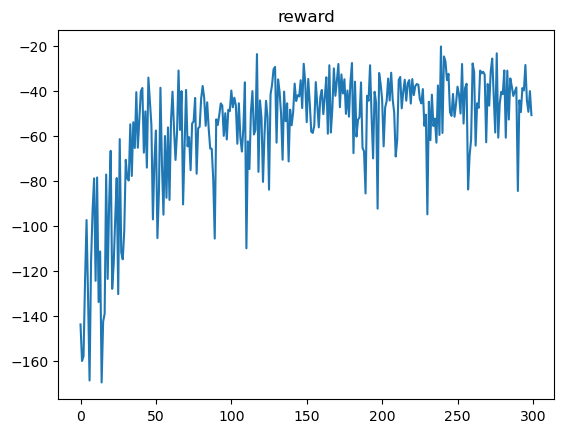

In [8]:
# 使用Matplotlib绘制奖励值的曲线图
plt.plot(episode_rewards[::100])
plt.title("reward")
plt.show()

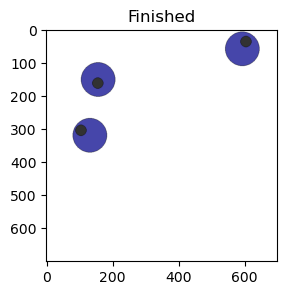

In [9]:
# 重置环境
observations, _ = env.reset()
# 创建GymHelper
gym_helper = GymHelper(env)
# 重置步数
steps = 0

while env.agents:
    # 渲染环境，title为当前步数
    gym_helper.render(title = str(steps))
    # 找到当前状态下的最优动作
    actions = agent.choose_action(observations, False)
    # 执行action，获取新的信息
    observations, rewards, terminations, truncations, infos = env.step(actions)
    # 记录步数
    steps += 1

# 游戏结束
gym_helper.render(title = "Finished")
# 关闭环境
env.close()